In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline

from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Load specific variables for each dataset

In [3]:
%run dataset-variables.py

version = 1
dataset = ../data/dataset-ucar-1979-2015-seq5-ystep5.nc
input_size = 32
step = 5
dropout rate = 0.0
learning rate = 0.001
upsample = False
upsample mode = None
param = {'encoder_layer_size': 2, 'decoder_layer_size': 2, 'kernel_size': 3, 'filter_size': 64}


In [4]:
util = Util('STConvS2S', version=version, prefix=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Seed

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Hyperparameters

In [7]:
epochs = 50
batch_size = 50
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [8]:
ds = xr.open_mfdataset(dataset_file)
#ds = ds[dict(sample=slice(0,500))]

In [9]:
train_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split)
val_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_validation=True)
test_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_test=True)

In [10]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([300, 1, 5, 32, 32])
[y_train] Shape: torch.Size([300, 1, 5, 32, 32])
[X_val] Shape: torch.Size([100, 1, 5, 32, 32])
[y_val] Shape: torch.Size([100, 1, 5, 32, 32])
[X_test] Shape: torch.Size([100, 1, 5, 32, 32])
[y_test] Shape: torch.Size([100, 1, 5, 32, 32])


In [11]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [12]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels, dropout_rate):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.dropout_rate = dropout_rate
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
            
    def learning_with_dropout(self, x):
        for conv, relu, batch, drop in zip(self.conv_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = drop(relu(batch(conv(x))))
            
        return x
    
    def learning_without_dropout(self, x):
        for conv, relu, batch in zip(self.conv_layers, self.relu_layers, self.batch_layers):
            x = relu(batch(conv(x)))
            
        return x
        
    def forward(self, input_):
        if self.dropout_rate > 0.:
            output = self.learning_with_dropout(input_)
        else:
            output = self.learning_without_dropout(input_)
        
        return output

In [13]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels, dropout_rate):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.dropout_rate = dropout_rate
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
        
    def learning_with_dropout(self, x):
        for conv, relu, batch, drop in zip(self.conv_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = drop(relu(batch(x)))
            
        return x
    
    def learning_without_dropout(self, x):            
        for conv, relu, batch in zip(self.conv_layers, self.relu_layers, self.batch_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = relu(batch(x))
            
        return x
        
    def forward(self, input_):
        if self.dropout_rate > 0.:
            output = self.learning_with_dropout(input_)
        else:
            output = self.learning_without_dropout(input_)
        
        return self.conv_final(output)

In [14]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels, dropout_rate):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                    initial_filter_size=filter_size, channels=channels, 
                                    dropout_rate=dropout_rate)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                    initial_filter_size=filter_size, channels=filter_size,
                                    dropout_rate=dropout_rate)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [15]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [16]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                  filter_size, channels=train_dataset.X.shape[1], 
                  dropout_rate=dropout_rate).to(device)
criterion = RMSELoss()

opt_params = {'lr': lr, 
              'alpha': 0.9, 
              'eps': 1e-6}

optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

Training the model

In [17]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                          device, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename)

Train on 300 samples, validate on 100 samples
Epoch: 1/50 - loss: 21.5861 - val_loss: 21.0514
=> Saving a new best
Epoch: 2/50 - loss: 20.9183 - val_loss: 21.0179
=> Saving a new best
Epoch: 3/50 - loss: 20.4725 - val_loss: 20.7793
=> Saving a new best
Epoch: 4/50 - loss: 20.0658 - val_loss: 20.3086
=> Saving a new best
Epoch: 5/50 - loss: 19.6695 - val_loss: 19.4286
=> Saving a new best
Epoch: 6/50 - loss: 19.2747 - val_loss: 18.7748
=> Saving a new best
Epoch: 7/50 - loss: 18.8708 - val_loss: 18.1168
=> Saving a new best
Epoch: 8/50 - loss: 18.4618 - val_loss: 17.5107
=> Saving a new best
Epoch: 9/50 - loss: 18.0432 - val_loss: 16.9642
=> Saving a new best
Epoch: 10/50 - loss: 17.6205 - val_loss: 16.7099
=> Saving a new best
Epoch: 11/50 - loss: 17.1766 - val_loss: 16.6022
=> Saving a new best
Epoch: 12/50 - loss: 16.7191 - val_loss: 16.0845
=> Saving a new best
Epoch: 13/50 - loss: 16.2504 - val_loss: 15.7769
=> Saving a new best
Epoch: 14/50 - loss: 15.7645 - val_loss: 14.7891
=> S

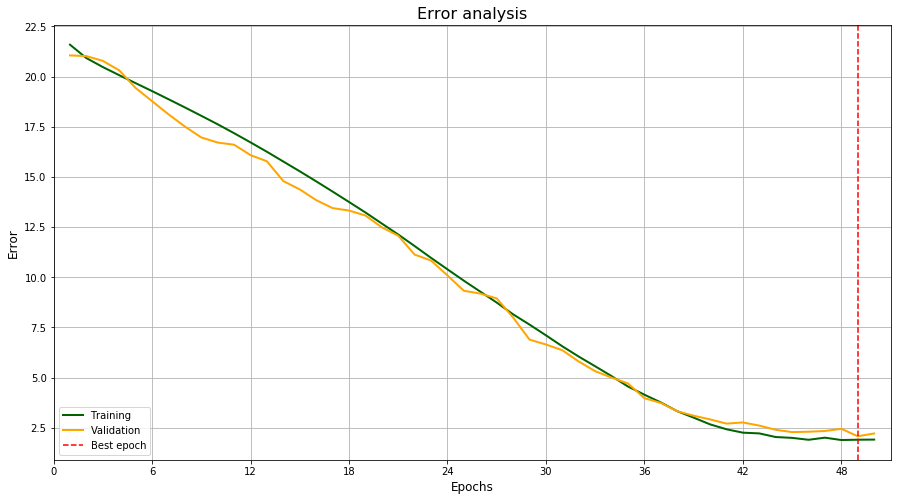

In [18]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Error', 'Error analysis', inline=True)

In [19]:
model,_, best_epoch, val_loss = trainer.load_checkpoint(checkpoint_filename)

=> Loaded checkpoint cfsr_1_20191011-210302.pth.tar (best epoch: 49, validation error: 2.0792)


Evaluating the model

In [20]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.eval()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 1.9345


In [21]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email (*uncomment the last line to send the email*)

In [23]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'e_layer': encoder_layer_size,
              'e_kernel_size': kernel_size,
              'e_filter': filter_size,
              'd_layer': decoder_layer_size,
              'd_kernel_size': kernel_size,
              'd_filter': filter_size,
              'dropout_rate': dropout_rate,
              'learning_rate': lr,
              'dataset': dataset,
              'hostname': platform.node()}

In [24]:
#util.send_email(model_info)

timestamp: 41.148335218429565
email sent
